# This is a notebook which helps understand OT using the transport plan splitting

\begin{align*}
\text{Minimize:} \quad & C(T_+) + C(T_-) \\
\text{Subject to:} \quad & T_+ \geq 0 \\
& T_- \geq 0 \\
& \text{rows}(T) = \text{rows}(T_+ - T_-) = \text{src dist.} \\
& \text{rows}(T) = \text{cols}(T_+ - T_-) = \text{target dist.}
\end{align*}

In [1]:
def create_constraints_signed(source, target):
    T_matrix_pos = cp.Variable((len(source), len(target)), nonneg=True)
    T_matrix_neg = cp.Variable((len(source), len(target)), nonneg=True)

    cons = [cp.sum(T_matrix_pos - T_matrix_neg, axis=0) == target,  # column sum should be what we move to the pixel the column represents
            cp.sum(T_matrix_pos - T_matrix_neg, axis=1) == source,  # row sum should be what we move from the pixel the row represents
            T_matrix_pos >= 0,  # all elements of both matrices should be non-negative
            T_matrix_neg >= 0,
            cp.diag(T_matrix_pos) == 0,  # Forces diagonal elements of T_matrix_pos to be zero
            cp.diag(T_matrix_neg) == 0 
           ]

    return T_matrix_pos, T_matrix_neg, cons


def calc_transport_cvxpy(source, target, cost_matrix):
    T_pos, T_neg, constraints = create_constraints_signed(source.flatten(), target.flatten())

    obj = cp.Minimize(cp.sum(cp.multiply(T_pos, cost_matrix)) + cp.sum(cp.multiply(T_neg, cost_matrix)))
    
    prob = cp.Problem(obj, constraints)
    
    prob.solve()

    return prob.value, T_pos.value, T_neg.value

def plot_transport_map(p, q, Transport_plan, title):
    plt.figure(figsize=(8, 8))
    plot1D_mat(p, q, Transport_plan, title)
    plt.show()

def solve_transport(source, target, cost_matrix):
    p, constraints = create_constraints(source, target)

    obj = cp.Minimize(cp.sum(cp.multiply(p, cost_matrix)))

    prob = cp.Problem(obj, constraints)
    prob.solve()

    return prob.value, p.value

## Is it a generalization?

In [2]:
from utils.utils import *

In [6]:
from utils.Visualizations import *

### Trivial case:

In [8]:
p = np.array([1,2,1,0,0])
q = np.array([0,0,1,2,1])

n_p = 5
n_q = 5

X,Y = np.linspace(0,1,n_p), np.linspace(0,1,n_q)

C = np.zeros([n_p,n_q],dtype=np.float64)

dist_f1 = lambda a,b : abs(a-b)
dist_f2 = lambda a,b : (a-b)**2
for it1 in range(n_p):
    for it2 in range(n_q):
        C[it1,it2] = dist_f2(X[it1],Y[it2])

In [9]:
C

array([[0.    , 0.0625, 0.25  , 0.5625, 1.    ],
       [0.0625, 0.    , 0.0625, 0.25  , 0.5625],
       [0.25  , 0.0625, 0.    , 0.0625, 0.25  ],
       [0.5625, 0.25  , 0.0625, 0.    , 0.0625],
       [1.    , 0.5625, 0.25  , 0.0625, 0.    ]])

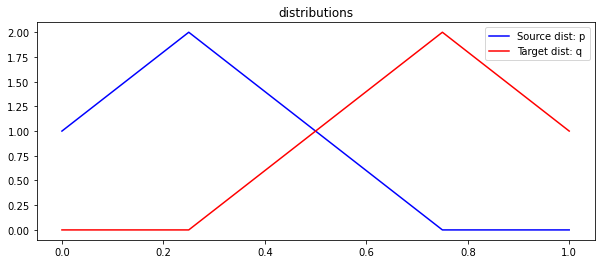

In [130]:
plot_distribution(X, p, q, 'distributions')

### Normal emd

In [131]:
transport_plan, transport_cost = calc_transport_pot_emd(p, q, C)

C:\Users\eriki\Documents\school\Thesis\Optimal_transport_playground\utils\utils.py:456: UserWarning: Input histogram consists of integer. The transport plan will be casted accordingly, possibly resulting in a loss of precision. If this behaviour is unwanted, please make sure your input histogram consists of floating point elements.
  Transport_plan = ot.emd(source.flatten(), target.flatten(), costs)


In [132]:
print(transport_cost)

1.0


### New approach

In [133]:
cost, T_pos, T_neg = calc_transport_cvxpy(p, q, C)

In [134]:
print(cost)

0.5000000000479383


In [135]:
print(transport_plan)

[[0 0 1 0 0]
 [0 0 0 2 0]
 [0 0 0 0 1]
 [0 0 0 0 0]
 [0 0 0 0 0]]


In [136]:
print(np.round(T_pos,3))

[[0. 1. 0. 0. 0.]
 [0. 0. 2. 0. 0.]
 [0. 0. 0. 2. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]]


In [137]:
print(np.round(T_neg,3))

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [138]:
print(np.round(T_pos-T_neg,3))

[[ 0.  1. -0.  0.  0.]
 [ 0.  0.  2. -0.  0.]
 [-0. -1. -0.  2. -0.]
 [ 0.  0. -1.  0.  1.]
 [ 0.  0. -0.  0.  0.]]


After looking at the 5x5 matrix, it is clear that using T_+,T_- will not be a generalization since it is prone to giving non-zero values only when close to the diagonal, since they are the cheapest.

## Gaussians:

In [49]:
n_p = 20
n_q = 20

p = make_1D_gauss(20, np.floor(2 * n_p / 4.), 2.)
q = make_1D_gauss(20, np.floor(5 * n_q / 8.), 2.)


X,Y = np.linspace(0,1,n_p), np.linspace(0,1,n_q)

C = np.zeros([n_p,n_q],dtype=np.float64)

dist_f1 = lambda a,b : abs(a-b)
dist_f2 = lambda a,b : (a-b)**2
for it1 in range(n_p):
    for it2 in range(n_q):
        C[it1,it2] = dist_f2(X[it1],Y[it2])

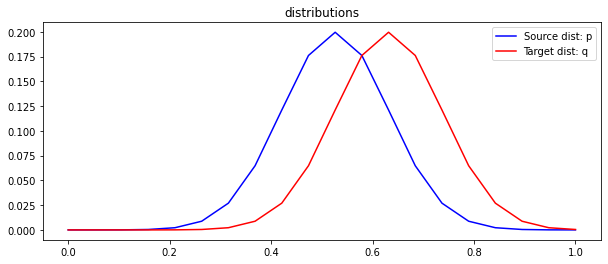

In [50]:
plot_distribution(X, p, q, 'distributions')

In [84]:
T_emd, T_emd_cost = calc_transport_pot_emd(p, q, C)

In [86]:
print(T_emd_cost)

0.011075324710522111


In [75]:
T_kant_cost, T_kant = solve_transport(p.flatten(), q.flatten(), C)

In [77]:
print(T_kant_cost)

0.011075325743928725


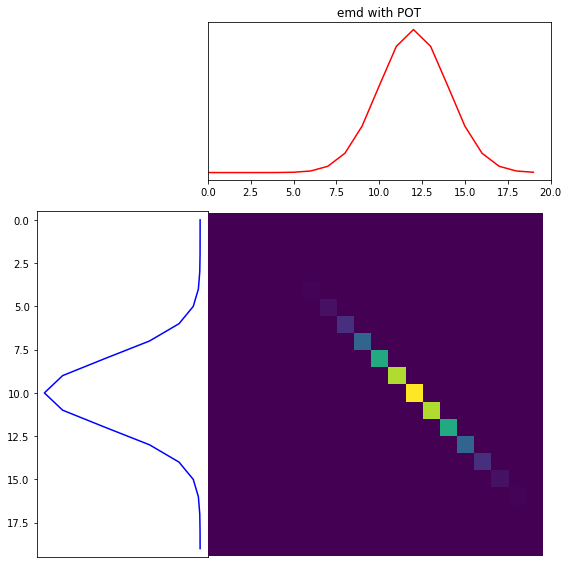

In [54]:
plot_transport_map(p, q, T_emd, 'emd with POT')

In [55]:
cost_pn, T_pos, T_neg = calc_transport_cvxpy(p, q, C)

In [63]:
print(cost_pn)

0.005538482209349112


In [57]:
T = T_pos - T_neg.T

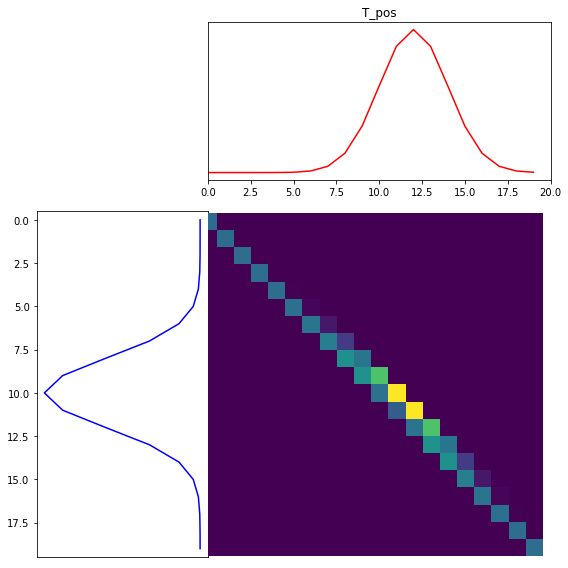

In [58]:
plot_transport_map(p, q, T_pos, 'T_pos')

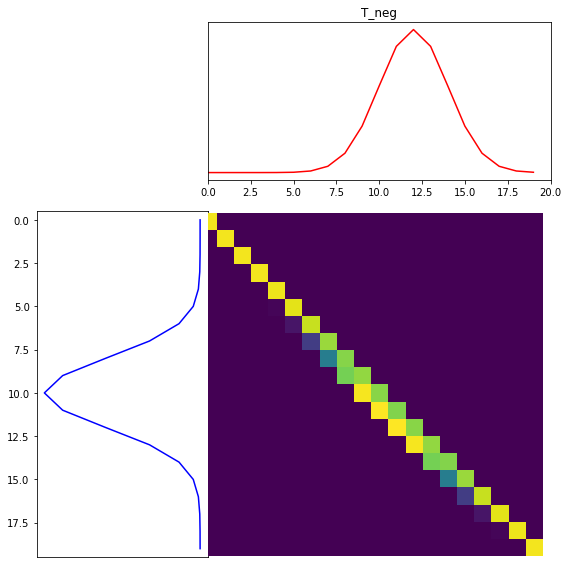

In [59]:
plot_transport_map(p, q, T_neg, 'T_neg')

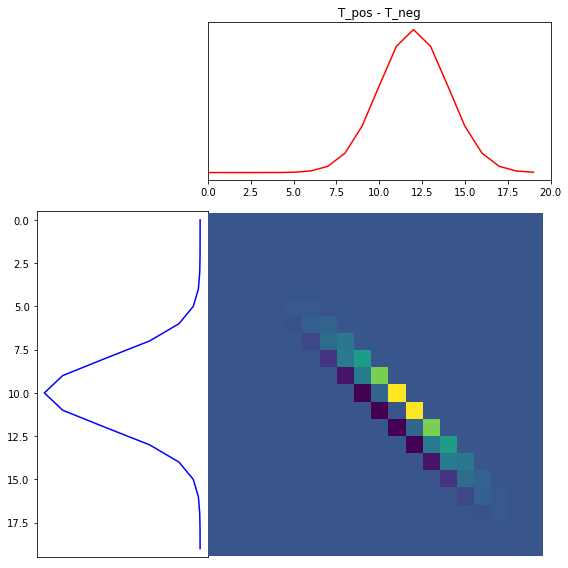

In [60]:
plot_transport_map(p, q, T_pos - T_neg, 'T_pos - T_neg')

In [26]:
np.allclose(T_pos - T_neg, transport_plan)

False

In [69]:
def plot_map_with_colorbar(T_map):
    fig, ax = plt.subplots()
    im = ax.imshow(T_map)

    # Add a colorbar
    cbar = plt.colorbar(im)

    # Display the plot
    plt.show()

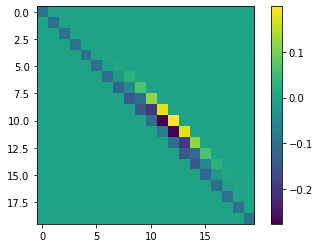

In [70]:
plot_map_with_colorbar(T_emd - T_pos)

In [78]:
temp = T_emd - T_pos

In [91]:
T_neg[0,0] - T_pos[0,0]

-3.757245269769838e-07

In [90]:
T_pos[0,0]

0.09799532862149037

In [27]:
T = T_pos - T_neg

In [30]:
(T - transport_plan).max()

0.11790432509357165

In [224]:
min_amount = min(min(p), min(q))
p_lifted = p - min_amount
q_lifted = q - min_amount
T_lifted, cost_lifted = calc_transport_pot_emd(p_lifted, q_lifted, C)

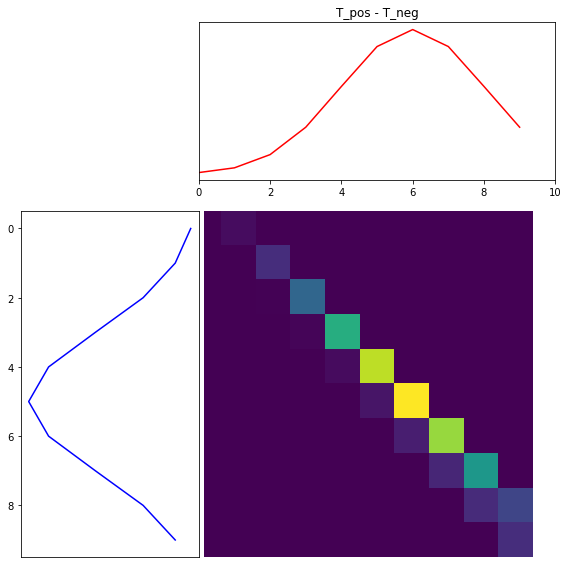

In [225]:
plot_transport_map(p, q, T_lifted, 'T_pos - T_neg')

In [31]:
x = cp.sum(T_pos - T_neg, axis = 0)

x = x.value

x - q.flatten()

array([0.11838765, 0.12207048, 0.12949143, 0.13666036, 0.13954259,
       0.14050972, 0.13413581, 0.12301153, 0.10900889, 0.09959555])

In [274]:
x = cp.sum(transport_plan, axis = 0)

x = x.value

x - q.flatten()

array([ 8.67361738e-19,  3.46944695e-18,  1.38777878e-17,  2.77555756e-17,
        8.32667268e-17,  5.55111512e-17,  1.11022302e-16,  5.55111512e-17,
        5.55111512e-17, -1.38777878e-16])

In [279]:
np.allclose(x, q.flatten(), atol=2e-1)

True

In [160]:
np.fill_diagonal(T_pos, 0)

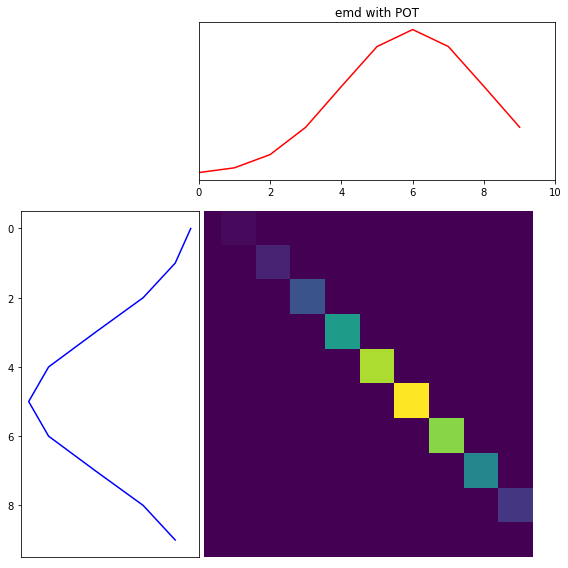

In [162]:
plot_transport_map(p, q, T_pos, 'emd with POT')

In [163]:
np.allclose(T_pos, transport_plan, atol=1e-3)

False

In [195]:
cost_cv, t_1 = solve_transport(p.flatten(), q.flatten(), C)

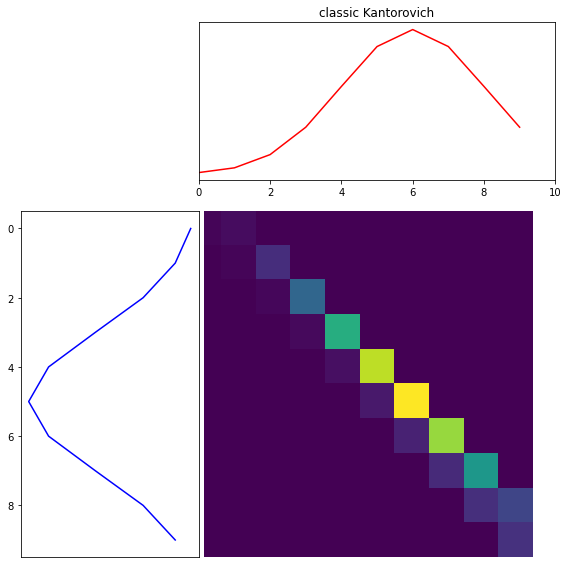

In [196]:
plot_transport_map(p,q,t_1,'classic Kantorovich')

To sum up, we can see that for the low dimensional case we get the correct result when splitting but when going higher, something gets messed up and we get different transport plans, specifically, T_- is not equal to zero.

In [141]:
cost_cv

0.011075325743928725